## Context

LendingClub is an American peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform. The company claims that $15.98 billion in loans had been originated through its platform up to December 31, 2015.

## Inspiration

This is great dataset to measure the credit risk of P2P lending loans from the Year 2015 to 2020.

<hr/>

# P2P Credit Risk Lending Prediction

<hr/>

Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model that can predict wether or nor a borrower will pay back their loan? This way in the future when **we get a new potential customer we can assess whether or not they are likely to pay back the loan.**

## Table of Contents

* [1. Import Dataset](#1)
* [2. Limit the Feature Space](#2)
 * [2.1 Drop features missing more than 30% data](#2.1)
 * [2.2 Only keep loan features known to potential investors](#2.2)
* [3. Data Analysis and Pre-processing](#3)
 * [3.1 Overlook on Data](#3.1)
 * [3.2  Pre-processing on each Variable](#3.2)
* [4. More Pre-processing](#4)
 * [4.1 Convert loan status to 0/1 charge-off indicator](#4.1)
 * [4.2 Create dummy variables](#4.2)
 * [4.3 Train/test split](#4.3)
* [5. Linear Dependence of Charge-off on the Predictors](#5)
 * [5.1 Pearson correlation](#5.1)
* [6. Model Training and Testing](#6)
 * [6.1 Logistic regression with SGD training](#6.1)
 * [6.2 Random forest classifier](#6.2)
 * [6.3 Tune hyperparameters on the chosen model more finely](#6.3)
 * [6.4 Test set evaluation](#6.4)
* [7. Conclusion](#7)

Link to the dataset: https://www.kaggle.com/ethon0426/lending-club-20072020q1


<a id="1"></a>
# 1. Setup and Import
<hr>

In [1]:
path ='data/Loan_status_2007-2020Q3.csv'

In [2]:
# # Files in dataset
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp

# visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

# scaling and train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
pd.set_option("display.precision", 4) # Show numbers only with 2 decimal places

# machine learning algorithm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score


# creating a model
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation
# from tensorflow.keras.constraints import max_norm
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.models import load_model

# evaluation on test data
from sklearn.metrics import classification_report,confusion_matrix
import shap


In [4]:
# Create dataframe from dataset file
loans = pd.read_csv(path, low_memory = False, index_col=0, )
loans.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0  1077501     5000.0       5000.0           4975.0   36 months   10.65%   
1  1077430     2500.0       2500.0           2500.0   60 months   15.27%   
2  1077175     2400.0       2400.0           2400.0   36 months   15.96%   
3  1076863    10000.0      10000.0          10000.0   36 months   13.49%   
4  1075358     3000.0       3000.0           3000.0   60 months   12.69%   

   installment grade sub_grade                 emp_title emp_length  \
0       162.87     B        B2                       NaN  10+ years   
1        59.83     C        C4                     Ryder   < 1 year   
2        84.33     C        C5                       NaN  10+ years   
3       339.31     C        C1       AIR RESOURCES BOARD  10+ years   
4        67.79     B        B5  University Medical Group     1 year   

  home_ownership  annual_inc verification_status   issue_d  loan_status  \
0           RENT     24000.0            Verified  Dec-2011   Fully Paid   
1           RENT     30000.0     Source Verified  Dec-2011  Charged Off   
2           RENT     12252.0        Not Verified  Dec-2011   Fully Paid   
3           RENT     49200.0     Source Verified  Dec-2011   Fully Paid   
4           RENT     80000.0     Source Verified  Dec-2011   Fully Paid   

  pymnt_plan  \
0          n   
1          n   
2          n   
3          n   
4          n   

                                                                url  \
0  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501   
1  https://lendingclub.com/browse/loanDetail.action?loan_id=1077430   
2  https://lendingclub.com/browse/loanDetail.action?loan_id=1077175   
3  https://lendingclub.com/browse/loanDetail.action?loan_id=1076863   
4  https://lendingclub.com/browse/loanDetail.action?loan_id=1075358   

          purpose                 title zip_code addr_state    dti  \
0     credit_card              Computer    860xx         AZ  27.65   
1             car                  bike    309xx         GA   1.00   
2  small_business  real estate business    606xx         IL   8.72   
3           other              personel    917xx         CA  20.00   
4           other              Personal    972xx         OR  17.94   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Jan-1985           735.0            739.0   
1          0.0         Apr-1999           740.0            744.0   
2          0.0         Nov-2001           735.0            739.0   
3          0.0         Feb-1996           690.0            694.0   
4          0.0         Jan-1996           695.0            699.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             1.0                     NaN                     NaN       3.0   
1             5.0                     NaN                     NaN       3.0   
2             2.0                     NaN                     NaN       2.0   
3             1.0                    35.0                     NaN      10.0   
4             0.0                    38.0                     NaN      15.0   

   pub_rec  revol_bal revol_util  total_acc initial_list_status  out_prncp  \
0      0.0    13648.0      83.7%        9.0                   f        0.0   
1      0.0     1687.0       9.4%        4.0                   f        0.0   
2      0.0     2956.0      98.5%       10.0                   f        0.0   
3      0.0     5598.0        21%       37.0                   f        0.0   
4      0.0    27783.0      53.9%       38.0                   f        0.0   

   out_prncp_inv  total_pymnt  total_pymnt_inv  total_rec_prncp  \
0            0.0    5863.1552          5833.84          5000.00   
1            0.0    1014.5300          1014.53           456.46   
2            0.0    3005.6668          3005.67          2400.00   
3            0.0   12231.8900         12231.89         10000.00   
4            0.0    4066.9082          4

In [5]:
loans.shape

(2925493, 141)

<a id="2"></a>
# 2. Limit the Feature Space

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

<a id="2.1"></a>
## 2.1 Drop features missing more than 30% data

In [6]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)
missing_fractions = missing_fractions.to_frame(name = 'percent_missing').reset_index()
missing_fractions.columns = ['col_name' , 'percent_missing']
missing_fractions.head()

col_name  percent_missing
0  hardship_loan_status           0.9510
1       hardship_reason           0.9509
2       hardship_status           0.9509
3          hardship_dpd           0.9509
4         hardship_type           0.9509

In [7]:
#Yash cell
hist = px.histogram(missing_fractions, x = "percent_missing")
hist.layout.yaxis.title.text = 'Count of Features'
hist.show()

In [8]:
# plt.figure(figsize=(6,3), dpi=90)
# missing_fractions.plot.hist(bins=20)
# plt.title('Histogram of Feature Incompleteness')
# plt.xlabel('Fraction of data missing')
# plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [9]:
loans.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0  1077501     5000.0       5000.0           4975.0   36 months   10.65%   
1  1077430     2500.0       2500.0           2500.0   60 months   15.27%   
2  1077175     2400.0       2400.0           2400.0   36 months   15.96%   
3  1076863    10000.0      10000.0          10000.0   36 months   13.49%   
4  1075358     3000.0       3000.0           3000.0   60 months   12.69%   

   installment grade sub_grade                 emp_title emp_length  \
0       162.87     B        B2                       NaN  10+ years   
1        59.83     C        C4                     Ryder   < 1 year   
2        84.33     C        C5                       NaN  10+ years   
3       339.31     C        C1       AIR RESOURCES BOARD  10+ years   
4        67.79     B        B5  University Medical Group     1 year   

  home_ownership  annual_inc verification_status   issue_d  loan_status  \
0           RENT     24000.0            Verified  Dec-2011   Fully Paid   
1           RENT     30000.0     Source Verified  Dec-2011  Charged Off   
2           RENT     12252.0        Not Verified  Dec-2011   Fully Paid   
3           RENT     49200.0     Source Verified  Dec-2011   Fully Paid   
4           RENT     80000.0     Source Verified  Dec-2011   Fully Paid   

  pymnt_plan  \
0          n   
1          n   
2          n   
3          n   
4          n   

                                                                url  \
0  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501   
1  https://lendingclub.com/browse/loanDetail.action?loan_id=1077430   
2  https://lendingclub.com/browse/loanDetail.action?loan_id=1077175   
3  https://lendingclub.com/browse/loanDetail.action?loan_id=1076863   
4  https://lendingclub.com/browse/loanDetail.action?loan_id=1075358   

          purpose                 title zip_code addr_state    dti  \
0     credit_card              Computer    860xx         AZ  27.65   
1             car                  bike    309xx         GA   1.00   
2  small_business  real estate business    606xx         IL   8.72   
3           other              personel    917xx         CA  20.00   
4           other              Personal    972xx         OR  17.94   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Jan-1985           735.0            739.0   
1          0.0         Apr-1999           740.0            744.0   
2          0.0         Nov-2001           735.0            739.0   
3          0.0         Feb-1996           690.0            694.0   
4          0.0         Jan-1996           695.0            699.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             1.0                     NaN                     NaN       3.0   
1             5.0                     NaN                     NaN       3.0   
2             2.0                     NaN                     NaN       2.0   
3             1.0                    35.0                     NaN      10.0   
4             0.0                    38.0                     NaN      15.0   

   pub_rec  revol_bal revol_util  total_acc initial_list_status  out_prncp  \
0      0.0    13648.0      83.7%        9.0                   f        0.0   
1      0.0     1687.0       9.4%        4.0                   f        0.0   
2      0.0     2956.0      98.5%       10.0                   f        0.0   
3      0.0     5598.0        21%       37.0                   f        0.0   
4      0.0    27783.0      53.9%       38.0                   f        0.0   

   out_prncp_inv  total_pymnt  total_pymnt_inv  total_rec_prncp  \
0            0.0    5863.1552          5833.84          5000.00   
1            0.0    1014.5300          1014.53           456.46   
2            0.0    3005.6668          3005.67          2400.00   
3            0.0   12231.8900         12231.89         10000.00   
4            0.0    4066.9082          4

In [10]:
drop_list = sorted(list(missing_fractions[missing_fractions.percent_missing > 0.3].col_name))
print(drop_list)
print("\n\n Drop Features: ", len(drop_list))

['annual_inc_joint', 'deferral_term', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'verification_status_joint']


 Drop Features:  37


In [11]:
# Drop these features
loans.drop(labels=drop_list, axis=1, inplace=True)

In [12]:
loans.shape

(2925493, 104)

<a id="2.2"></a>
## 2.2 Only keep loan features known to potential investors

In [13]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', '

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

In [14]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']
print("Keep features: ", len(keep_list))

Keep features:  31


In [15]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

print("\n\nNumber of features needed to be dropped: ",len(drop_list))

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_

In [16]:
loans.drop(labels=drop_list, axis=1, inplace=True)
loans.shape

(2925493, 31)

<a id="3"></a>
# 3. Data Analysis and Pre-processing

* Overlook on Data
* Pre-processing on each Variable

<a id="3.1"></a>
## 3.1 Overlook on Data

In [17]:
print("Records: ", loans.shape[0], "\nFeatures: ", loans.shape[1])
print("\nInformation of Dataset\n-------")
loans.info()

Records:  2925493 
Features:  31

Information of Dataset
-------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925493 entries, 0 to 105450
Data columns (total 31 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    object 
 1   loan_amnt             float64
 2   term                  object 
 3   int_rate              object 
 4   installment           float64
 5   grade                 object 
 6   sub_grade             object 
 7   emp_title             object 
 8   emp_length            object 
 9   home_ownership        object 
 10  annual_inc            float64
 11  verification_status   object 
 12  issue_d               object 
 13  loan_status           object 
 14  purpose               object 
 15  title                 object 
 16  zip_code              object 
 17  addr_state            object 
 18  dti                   float64
 19  earliest_cr_line      object 
 20  fico_range_low        float64
 21  fico_range_hi

In [18]:
loans.head(50)

id  loan_amnt        term int_rate  installment grade sub_grade  \
0   1077501     5000.0   36 months   10.65%       162.87     B        B2   
1   1077430     2500.0   60 months   15.27%        59.83     C        C4   
2   1077175     2400.0   36 months   15.96%        84.33     C        C5   
3   1076863    10000.0   36 months   13.49%       339.31     C        C1   
4   1075358     3000.0   60 months   12.69%        67.79     B        B5   
5   1075269     5000.0   36 months    7.90%       156.46     A        A4   
6   1069639     7000.0   60 months   15.96%       170.08     C        C5   
7   1072053     3000.0   36 months   18.64%       109.43     E        E1   
8   1071795     5600.0   60 months   21.28%       152.39     F        F2   
9   1071570     5375.0   60 months   12.69%       121.45     B        B5   
10  1070078     6500.0   60 months   14.65%       153.45     C        C3   
11  1069908    12000.0   36 months   12.69%       402.54     B        B5   
12  1064687     9000.0   36 months   13.49%       305.38     C        C1   
13  1069866     3000.0   36 months    9.91%        96.68     B        B1   
14  1069057    10000.0   36 months   10.65%       325.74     B        B2   
15  1069759     1000.0   36 months   16.29%        35.31     D        D1   
16  1065775    10000.0   36 months   15.27%       347.98     C        C4   
17  1069971     3600.0   36 months    6.03%       109.57     A        A1   
18  1062474     6000.0   36 months   11.71%       198.46     B        B3   
19  1069742     9200.0   36 months    6.03%       280.01     A        A1   
20  1069740    20250.0   60 months   15.27%       484.63     C        C4   
21  1039153    21000.0   36 months   12.42%       701.73     B        B4   
22  1069710    10000.0   36 months   11.71%       330.76     B        B3   
23  1069700    10000.0   36 months   11.71%       330.76     B        B3   
24  1069559     6000.0   36 months   11.71%       198.46     B        B3   
25  1069697    15000.0   36 months    9.91%       483.38     B        B1   
26  1069800    15000.0   36 months   14.27%       514.64     C        C2   
27  1069657     5000.0   60 months   16.77%       123.65     D        D2   
28  1069799     4000.0   36 months   11.71%       132.31     B        B3   
29  1047704     8500.0   36 months   11.71%       281.15     B        B3   
30  1032111     4375.0   36 months    7.51%       136.11     A        A3   
31  1069539    31825.0   36 months    7.90%       995.82     A        A4   
32  1065420    10000.0   60 months   15.96%       242.97     C        C5   
33  1069591     5000.0   36 months    8.90%       158.77     A        A5   
34  1069530     7000.0   36 months   15.96%       245.97     C        C5   
35  1069522    12400.0   36 months   10.65%       403.91     B        B2   
36  1069361    10800.0   36 months    9.91%       348.03     B        B1   
37  1069357    15000.0   36 months    7.90%       469.36     A        A4   
38  1069356     6000.0   36 months   12.42%       200.50     B        B4   
39  1069346    12500.0   60 months   12.69%       282.44     B        B5   
40  1067573     9600.0   36 months    7.51%       298.67     A        A3   
41  1069506    12000.0   36 months    7.90%       375.49     A        A4   
42  1069314     3000.0   36 months   18.25%       108.84     D        D5   
43  1060578     4400.0   36 months   16.77%       156.37     D        D2   
44  1069469     6000.0   36 months    6.03%       182.62     A        A1   
45  1051117    14000.0   36 months    9.91%       451.15     B        B1   
46  1069465     5000.0   36 months    8.90%       158.77     A        A5   
47  1069283    10000.0   36 months   10.65%       325.74     B        B2   
48  1069287    10000.0   36 months    6.03%       304.36     A        A1   
49  1069453    11000.0   36 months    6.62%       337.75     A        A2   

                                   emp_title emp_length home_ownership  \
0                                        NaN  10+ years   

In [19]:
loans.describe()

loan_amnt  installment  annual_inc         dti  fico_range_low  \
count  2.9255e+06   2.9255e+06  2.9255e+06  2.9224e+06      2.9255e+06   
mean   1.5359e+04   4.5239e+02  7.9937e+04  1.9296e+01      7.0051e+02   
std    9.4784e+03   2.7295e+02  1.1175e+05  1.5720e+01      3.3766e+01   
min    5.0000e+02   4.9300e+00  0.0000e+00 -1.0000e+00      6.1000e+02   
25%    8.0000e+03   2.5350e+02  4.7000e+04  1.2080e+01      6.7500e+02   
50%    1.3000e+04   3.8230e+02  6.6000e+04  1.8100e+01      6.9500e+02   
75%    2.0000e+04   6.0392e+02  9.5000e+04  2.4880e+01      7.2000e+02   
max    4.0000e+04   1.7198e+03  1.1000e+08  9.9900e+02      8.4500e+02   

       fico_range_high    open_acc     pub_rec   revol_bal   total_acc  \
count       2.9255e+06  2.9255e+06  2.9255e+06  2.9255e+06  2.9255e+06   
mean        7.0451e+02  1.1676e+01  1.7628e-01  1.6965e+04  2.4018e+01   
std         3.3767e+01  5.7333e+00  5.2438e-01  2.2996e+04  1.2076e+01   
min         6.1400e+02  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00   
25%         6.7900e+02  8.0000e+00  0.0000e+00  5.9930e+03  1.5000e+01   
50%         6.9900e+02  1.1000e+01  0.0000e+00  1.1493e+04  2.2000e+01   
75%         7.2400e+02  1.5000e+01  0.0000e+00  2.0644e+04  3.1000e+01   
max         8.5000e+02  1.0400e+02  8.6000e+01  2.9048e+06  1.7600e+02   

         mort_acc  pub_rec_bankruptcies  
count  2.8755e+06            2.9241e+06  
mean   1.5123e+00            1.2268e-01  
std    1.8698e+00            3.5314e-01  
min    0.0000e+00            0.0000e+00  
25%    0.0000e+00            0.0000e+00  
50%    1.0000e+00            0.0000e+00  
75%    2.0000e+00            0.0000e+00  
max    9.4000e+01            1.2000e+01

In [20]:
# Target Variable
loans['loan_status'].value_counts(dropna=False)

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
NaN                                                          1
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [21]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [22]:
# Categories in percentage
loans['loan_status'].value_counts(normalize=True, dropna=False)*100

Fully Paid     80.5116
Charged Off    19.4884
Name: loan_status, dtype: float64

* This is an imbalance problem, because we have a lot more entries of people that fully paid their loans then people that did not pay back.
* We can expect to probably do very well in terms of accuracy but our precision and recall are going to be the true metrics that we will have to evaluate our model based off of.

* In the loan amount distribution we can see spikes in even ten thousend dollar, so this is indicating that there are certain amounts that are basically standard loans.

<a id="3.2"></a>
## 3.2 Pre-processing on each Variable

We'll inspect each feature individually, and do the following:

1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

We define a function for plotting a variable and comparing with the loan status:

In [23]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

Print the remaining features for future reference:

In [24]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


### 3.2.1 id

Data Dictionary: "A unique [LendingClub] assigned ID for the loan listing."

Are all the IDs unique?

In [25]:
loans['id'].describe()

count       1860331
unique      1860331
top       113846917
freq              1
Name: id, dtype: object

Yes, they are all unique. The ID is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [26]:
loans.drop('id', axis=1, inplace=True)

### 3.2.2 loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [27]:
loans['loan_amnt'].describe()

count    1.8603e+06
mean     1.4588e+04
std      8.9705e+03
min      5.0000e+02
25%      7.9500e+03
50%      1.2000e+04
75%      2.0000e+04
max      4.0000e+04
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$40,000, with a median of \$12,000.

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



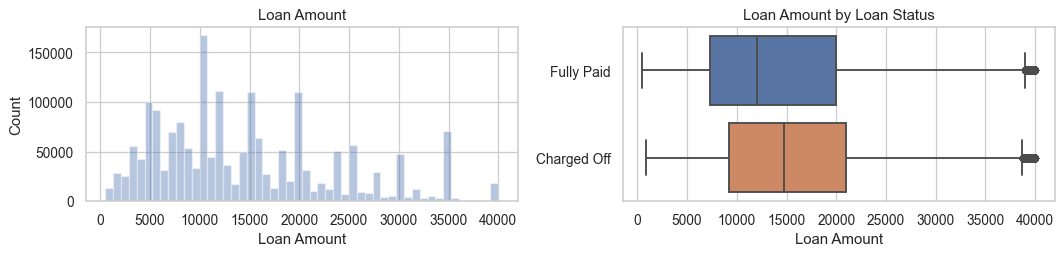

In [28]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [29]:
loans.groupby('loan_status')['loan_amnt'].describe()

count        mean        std    min     25%      50%  \
loan_status                                                             
Charged Off   362548.0  15899.4960  9083.2622  900.0  9250.0  14700.0   
Fully Paid   1497783.0  14270.8825  8914.0119  500.0  7350.0  12000.0   

                 75%      max  
loan_status                    
Charged Off  21000.0  40000.0  
Fully Paid   20000.0  40000.0

### 3.2.3 term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [30]:
loans['term'].value_counts(dropna=False)

 36 months    1393299
 60 months     467032
Name: term, dtype: int64

Convert `term` to integers.

In [31]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))
loans['term'].value_counts(normalize=True)

36    0.749
60    0.251
Name: term, dtype: float64

Compare the charge-off rate by loan period:

In [32]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.1562
60    0.3102
Name: loan_status, dtype: float64

About 75% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

### 3.2.4 int_rate

Data Dictionary: "Interest Rate on the loan."

In [33]:
# Let's remove % percent sign from `int_rate` and convert it into `float`
loans.int_rate = loans.int_rate.map(lambda x: x.replace('%','')).astype(np.float64)

In [34]:
loans['int_rate'].describe()

count    1.8603e+06
mean     1.3170e+01
std      4.8283e+00
min      5.3100e+00
25%      9.5600e+00
50%      1.2690e+01
75%      1.5990e+01
max      3.0990e+01
Name: int_rate, dtype: float64

Interest rates range from 5.32% to 31% (!) with a median of 13.2%.

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



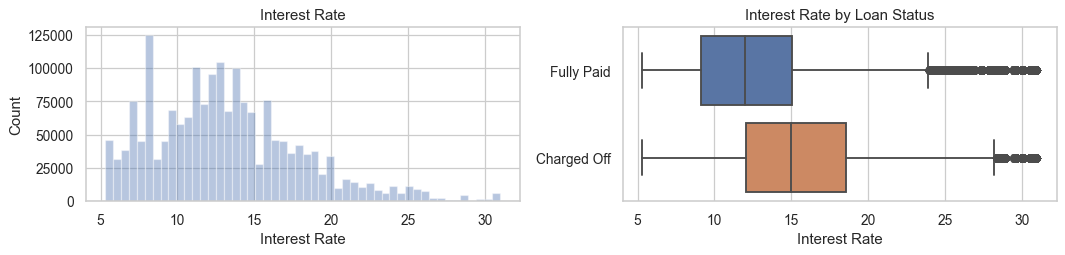

In [35]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [36]:
loans.groupby('loan_status')['int_rate'].describe()

count     mean     std   min    25%    50%    75%    max
loan_status                                                              
Charged Off   362548.0  15.6559  5.0217  5.31  12.05  14.99  18.55  30.99
Fully Paid   1497783.0  12.5684  4.5819  5.31   9.16  11.99  15.05  30.99

### 3.2.5 installment
<a id="3.2.5"></a>

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [37]:
loans['installment'].describe()

count    1.8603e+06
mean     4.4026e+02
std      2.6691e+02
min      4.9300e+00
25%      2.4699e+02
50%      3.7363e+02
75%      5.8496e+02
max      1.7198e+03
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,714, with a median of \$377.

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



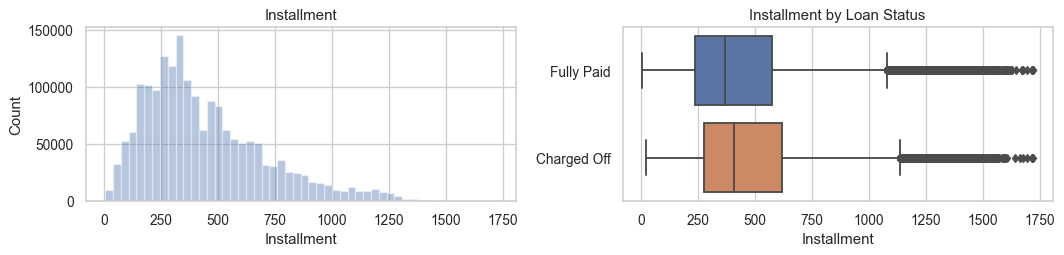

In [38]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [39]:
loans.groupby('loan_status')['installment'].describe()

count      mean       std    min     25%     50%      75%  \
loan_status                                                                  
Charged Off   362548.0  472.7604  268.4462  21.62  277.41  407.26  620.750   
Fully Paid   1497783.0  432.3879  265.9396   4.93  238.17  366.37  575.105   

                 max  
loan_status           
Charged Off  1717.63  
Fully Paid   1719.83

Loans that charge off have \$30 higher installments on average.

### 3.2.6 grade, sub_grade

Data Dictionary for `grade`: "LendingClub assigned loan grade."

Data Dictionary for `sub_grade`: "LendingClub assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [40]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [41]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [42]:
loans.drop('grade', axis=1, inplace=True)

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



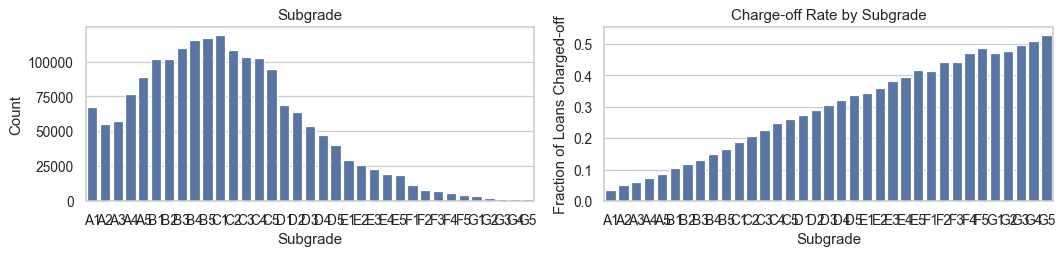

In [43]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

### 3.2.7 emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [44]:
loans['emp_title'].describe()

count     1728877
unique     456676
top       Teacher
freq        30748
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.

In [45]:
loans.drop(labels='emp_title', axis=1, inplace=True)

### 3.2.8 emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [46]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year       122924
10+ years    611330
2 years      168516
3 years      149271
4 years      112211
5 years      115872
6 years       85354
7 years       78141
8 years       78646
9 years       67170
< 1 year     153700
NaN          117196
Name: emp_length, dtype: int64

Note there are 117126 loans without data on the length of employment.

Convert `emp_length` to integers:

In [47]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [48]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [49]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [50]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [51]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.0     153700
1.0     122924
2.0     168516
3.0     149271
4.0     112211
5.0     115872
6.0      85354
7.0      78141
8.0      78646
9.0      67170
10.0    611330
NaN     117196
Name: emp_length, dtype: int64

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



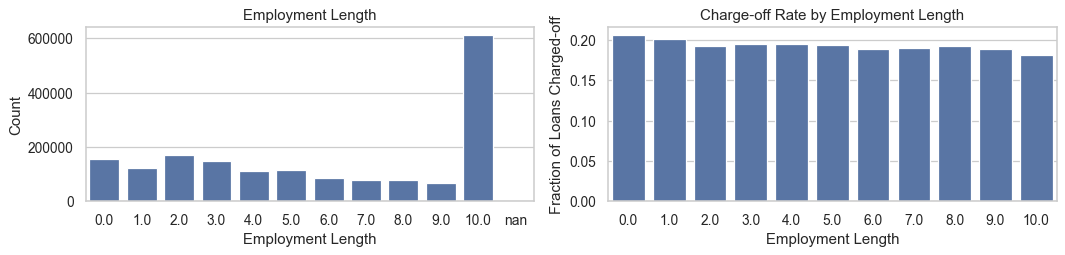

In [52]:
plot_var('emp_length', 'Employment Length', continuous=False)

In [53]:
loans.drop('emp_length', axis=1, inplace=True)

Loan status does not appear to vary much with employment length on average, except for a small drop in charge-offs for borrowers with over 10 years of employment.

### 3.2.9 home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [54]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    918028
RENT        735358
OWN         205578
ANY           1174
OTHER          144
NONE            49
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [55]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [56]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    918028
RENT        735358
OWN         205578
OTHER         1367
Name: home_ownership, dtype: int64

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



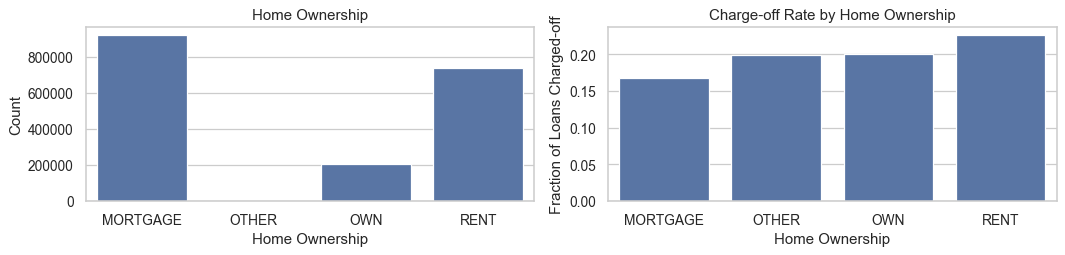

In [57]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in charge-off rates by home ownership status. Renters and homeowners have a higher probability of charge-off. Let's compare the charge-off rates:

In [58]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.1683
OTHER       0.1997
OWN         0.2011
RENT        0.2263
Name: loan_status, dtype: float64

### 3.2.10 annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [59]:
loans['annual_inc'].describe()

count    1.8603e+06
mean     7.7370e+04
std      1.1782e+05
min      0.0000e+00
25%      4.6000e+04
50%      6.5000e+04
75%      9.2000e+04
max      1.1000e+08
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [60]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [61]:
loans.drop('annual_inc', axis=1, inplace=True)

In [62]:
loans['log_annual_inc'].describe()

count    1.8603e+06
mean     4.8147e+00
std      2.6617e-01
min      0.0000e+00
25%      4.6628e+00
50%      4.8129e+00
75%      4.9638e+00
max      8.0414e+00
Name: log_annual_inc, dtype: float64

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



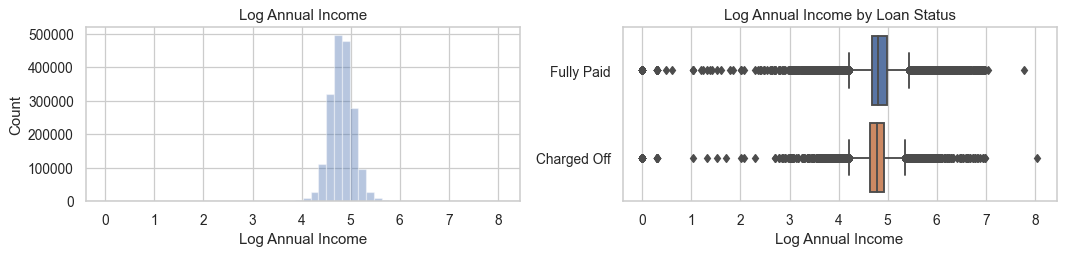

In [63]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [64]:
loans.groupby('loan_status')['log_annual_inc'].describe()

count    mean     std  min     25%     50%     75%     max
loan_status                                                                
Charged Off   362548.0  4.7852  0.2630  0.0  4.6435  4.7782  4.9294  8.0414
Fully Paid   1497783.0  4.8219  0.2664  0.0  4.6721  4.8129  4.9777  7.7853

### 3.2.11 verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



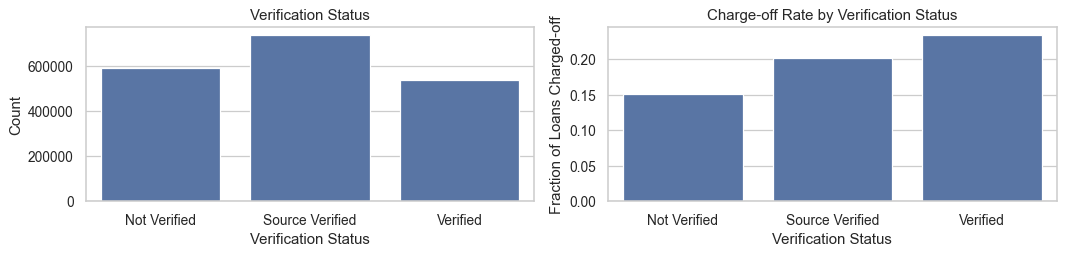

In [65]:
plot_var('verification_status', 'Verification Status', continuous=False)

### 3.2.12 issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, `issue_d` will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

### 3.2.13 purpose

Data Dictionary: "A category provided by the borrower for the loan request."

In [66]:
loans['purpose'].value_counts()

debt_consolidation    1063459
credit_card            412844
home_improvement       123861
other                  113589
major_purchase          41750
medical                 22578
small_business          20515
car                     20215
vacation                13333
moving                  13203
house                   11099
wedding                  2298
renewable_energy         1260
educational               327
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [67]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.1218
car                   0.1412
credit_card           0.1685
educational           0.1713
home_improvement      0.1722
vacation              0.1780
major_purchase        0.1847
other                 0.2002
medical               0.2040
debt_consolidation    0.2064
renewable_energy      0.2167
moving                0.2209
house                 0.2217
small_business        0.2858
Name: loan_status, dtype: float64

Notice that only 12% of completed loans for weddings have charged-off, but 30% of completed small business loans have charged-off.

### 3.2.14 title

Data Dictionary: "The loan title provided by the borrower."

In [68]:
loans['title'].describe()

count                1838925
unique                 61685
top       Debt consolidation
freq                  941169
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [69]:
loans['title'].value_counts().head(10)

Debt consolidation         941169
Credit card refinancing    366391
Home improvement           111152
Other                      102322
Major purchase              36294
Medical expenses            20548
Business                    16806
Car financing               16802
Debt Consolidation          15695
Vacation                    12273
Name: title, dtype: int64

There are 60,298 different titles in the dataset, and based on the top 10 titles, the `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [70]:
loans.drop('title', axis=1, inplace=True)

### 3.2.15 zip_code, addr_state

Data Dictionary for `zip_code`: "The first 3 numbers of the zip code provided by the borrower in the loan application."

Data Dictionary for `addr_state`: "The state provided by the borrower in the loan application."

In [71]:
loans['zip_code'].sample(5)

66567     440xx
68809     016xx
110247    088xx
28360     750xx
30821     063xx
Name: zip_code, dtype: object

In [72]:
loans['zip_code'].nunique()

949

In [73]:
loans['addr_state'].sample(5)

229346    TX
200564    IL
97998     OK
132143    WA
398716    CA
Name: addr_state, dtype: object

In [74]:
loans['addr_state'].nunique()

51

There are a lot of different zip codes, so let's just keep the state column.

In [75]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the charge-off rates by address state:

In [76]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
ME    0.1282
VT    0.1311
DC    0.1350
OR    0.1418
IA    0.1429
NH    0.1485
WV    0.1491
CO    0.1526
WA    0.1534
SC    0.1552
MT    0.1604
ID    0.1624
WY    0.1627
UT    0.1635
KS    0.1658
RI    0.1760
IL    0.1780
CT    0.1784
ND    0.1831
WI    0.1835
GA    0.1844
MA    0.1868
DE    0.1891
AK    0.1895
AZ    0.1900
MN    0.1920
VA    0.1927
OH    0.1930
MI    0.1934
TX    0.1945
CA    0.1946
KY    0.1985
PA    0.1998
NC    0.1998
SD    0.2012
HI    0.2021
MO    0.2023
NJ    0.2031
TN    0.2034
IN    0.2037
NM    0.2059
MD    0.2093
FL    0.2141
NV    0.2147
NY    0.2160
LA    0.2216
NE    0.2248
OK    0.2267
AL    0.2271
AR    0.2360
MS    0.2489
Name: loan_status, dtype: float64

The charge-off rate ranges from 13.0% in Washington, DC to 27.6% in Mississippi.

### 3.2.16 dti

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [77]:
loans['dti'].describe()

count    1.8592e+06
mean     1.8568e+01
std      1.3092e+01
min     -1.0000e+00
25%      1.1820e+01
50%      1.7710e+01
75%      2.4290e+01
max      9.9900e+02
Name: dti, dtype: float64

Note sure if the values of -1 and 999 make sense...

There are several outliers that mess up our default plots. Plot a histogram for `dti` less than 60:

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Debt-to-income Ratio')

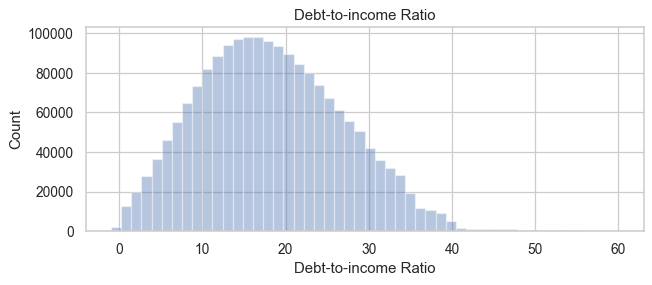

In [78]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

How many of the `dti` values are "outliers" (above 60)?

In [79]:
(loans['dti']>=60).sum()

4874

Very few. Compare the summary statistics by loan status:

In [80]:
loans.groupby('loan_status')['dti'].describe()

count     mean      std  min    25%    50%    75%    max
loan_status                                                              
Charged Off   362325.0  20.2683  14.2722  0.0  13.27  19.60  26.31  999.0
Fully Paid   1496898.0  18.1561  12.7553 -1.0  11.52  17.29  23.76  999.0

Completed loans that are charged off tend to have higher debt-to-income ratios.

### 3.2.17 earliest_cr_line

Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [81]:
loans['earliest_cr_line'].sample(5)

67113     Apr-2002
9966      Sep-1988
143909    Dec-1980
128824    Sep-2006
33897     Dec-1994
Name: earliest_cr_line, dtype: object

In [82]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [83]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [84]:
loans['earliest_cr_line'].describe()

count    1.8603e+06
mean     1.9993e+03
std      7.7717e+00
min      1.9330e+03
25%      1.9950e+03
50%      2.0010e+03
75%      2.0050e+03
max      2.0170e+03
Name: earliest_cr_line, dtype: float64

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



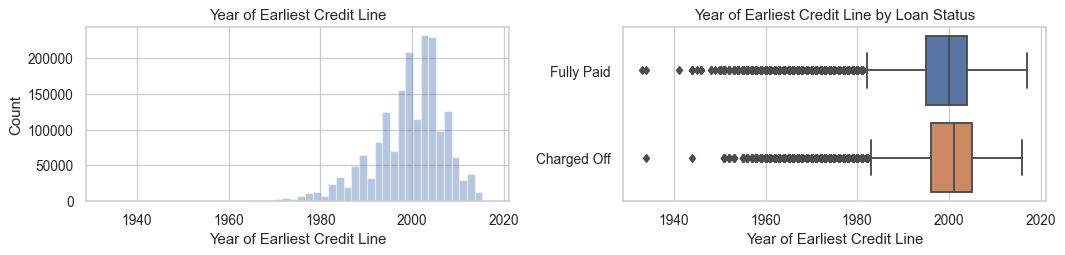

In [85]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who are charged-off tend to have shorter lines of credit.

### 3.2.18 fico_range_low, fico_range_high

Data Dictionary for `fico_range_low`: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for `fico_range_high`: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [86]:
loans[['fico_range_low', 'fico_range_high']].describe()

fico_range_low  fico_range_high
count      1.8603e+06       1.8603e+06
mean       6.9768e+02       7.0168e+02
std        3.2709e+01       3.2709e+01
min        6.2500e+02       6.2900e+02
25%        6.7000e+02       6.7400e+02
50%        6.9000e+02       6.9400e+02
75%        7.1500e+02       7.1900e+02
max        8.4500e+02       8.5000e+02

Check the Pearson correlation between these values:

In [87]:
loans[['fico_range_low','fico_range_high']].corr()

fico_range_low  fico_range_high
fico_range_low              1.0              1.0
fico_range_high             1.0              1.0

We only need to keep one of the FICO scores. We'll take the average of the two and call it `fico_score`:

In [88]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [89]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



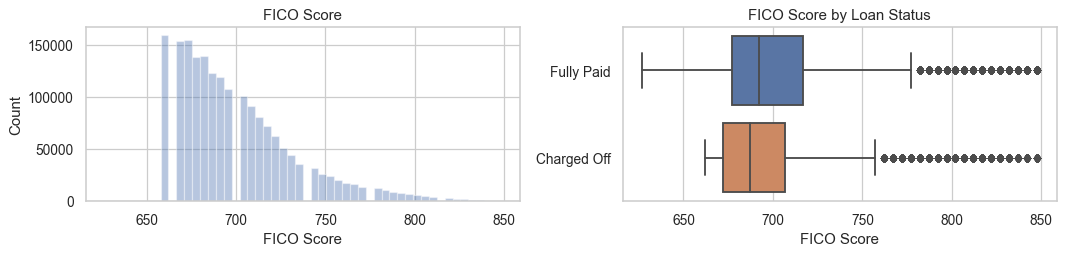

In [90]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is a noticeable difference in FICO scores between fully paid and charged-off loans. Compare the summary statistics:

In [91]:
loans.groupby('loan_status')['fico_score'].describe()

count      mean      std    min    25%    50%    75%    max
loan_status                                                                 
Charged Off   362548.0  691.6664  27.3203  662.0  672.0  687.0  707.0  847.5
Fully Paid   1497783.0  701.6180  33.5988  627.0  677.0  692.0  717.0  847.5

Loans that charge off have a FICO score 10 points lower on average.

### 3.2.19 open_acc

Data Dictionary: "The number of open credit lines in the borrower's credit file."

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Number of Open Credit Lines')

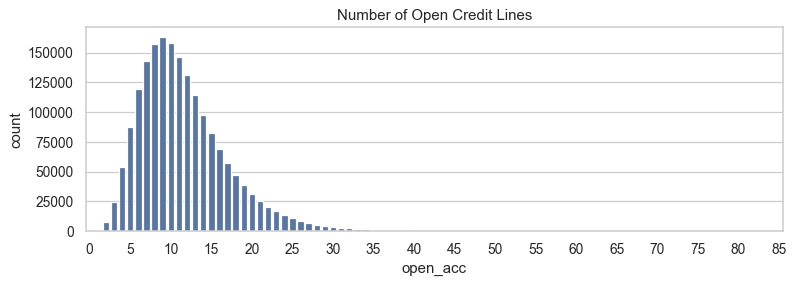

In [92]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(loans['open_acc'], order=sorted(loans['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Is there a difference in number of credit lines between fully paid loans and charged-off loans?

In [93]:
loans.groupby('loan_status')['open_acc'].describe()

count     mean     std  min  25%   50%   75%   max
loan_status                                                        
Charged Off   362548.0  11.8453  5.7211  0.0  8.0  11.0  15.0  78.0
Fully Paid   1497783.0  11.5480  5.5381  0.0  8.0  11.0  14.0  90.0

### 3.2.20 pub_rec

Data Dictionary: "Number of derogatory public records."

In [94]:
loans['pub_rec'].value_counts().sort_index()

0.0     1552452
1.0      260561
2.0       30892
3.0        9484
4.0        3473
5.0        1656
6.0         830
7.0         379
8.0         214
9.0         118
10.0         77
11.0         55
12.0         32
13.0         22
14.0         10
15.0         10
16.0          9
17.0          5
18.0          6
19.0          7
20.0          3
21.0          6
22.0          3
23.0          2
24.0          3
25.0          1
28.0          4
31.0          1
32.0          1
34.0          1
37.0          1
40.0          1
44.0          1
45.0          1
46.0          1
47.0          1
49.0          2
52.0          1
54.0          1
61.0          2
63.0          1
86.0          1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [95]:
loans.groupby('loan_status')['pub_rec'].describe()

count    mean     std  min  25%  50%  75%   max
loan_status                                                     
Charged Off   362548.0  0.2371  0.6379  0.0  0.0  0.0  0.0  86.0
Fully Paid   1497783.0  0.2013  0.5778  0.0  0.0  0.0  0.0  63.0

### 3.2.21 revol_bal

Data Dictionary: "Total credit revolving balance."

In [96]:
loans['revol_bal'].describe()

count    1.8603e+06
mean     1.6285e+04
std      2.2468e+04
min      0.0000e+00
25%      5.8420e+03
50%      1.1070e+04
75%      1.9770e+04
max      2.9048e+06
Name: revol_bal, dtype: float64

Do a log transform:

In [97]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [98]:
loans.drop('revol_bal', axis=1, inplace=True)

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



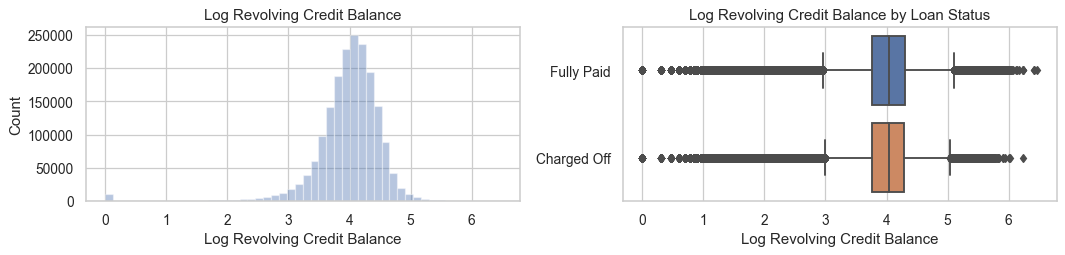

In [99]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [100]:
loans.groupby('loan_status')['log_revol_bal'].describe()

count    mean     std  min     25%     50%     75%     max
loan_status                                                                
Charged Off   362548.0  3.9733  0.5392  0.0  3.7661  4.0391  4.2785  6.2422
Fully Paid   1497783.0  3.9877  0.5519  0.0  3.7667  4.0455  4.3004  6.4631

There isn't a large difference in the means.

### 3.2.22 revol_util

Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [101]:
# Let's remove % percent sign from `revol_util` and convert it into `float`
loans.revol_util = loans.revol_util.map(lambda x: str(x).replace('%','')).astype(np.float64)
loans['revol_util'].head()

0    83.7
1     9.4
2    98.5
3    21.0
4    53.9
Name: revol_util, dtype: float64

In [102]:
loans['revol_util'].describe()

count    1.8589e+06
mean     5.0464e+01
std      2.4790e+01
min      0.0000e+00
25%      3.1600e+01
50%      5.0500e+01
75%      6.9600e+01
max      8.9230e+02
Name: revol_util, dtype: float64

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



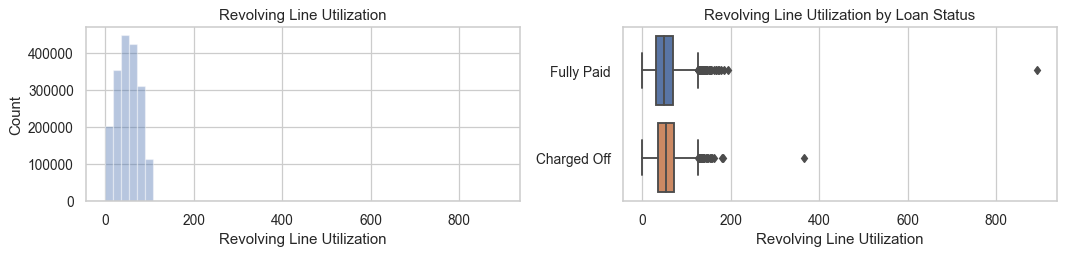

In [103]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [104]:
loans.groupby('loan_status')['revol_util'].describe()

count     mean      std  min   25%   50%   75%    max
loan_status                                                           
Charged Off   362279.0  52.9553  24.2451  0.0  35.0  53.5  71.6  366.6
Fully Paid   1496654.0  49.8614  24.8825  0.0  30.8  49.8  69.0  892.3

### 3.2.23 total_acc

Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Total Number of Credit Lines')

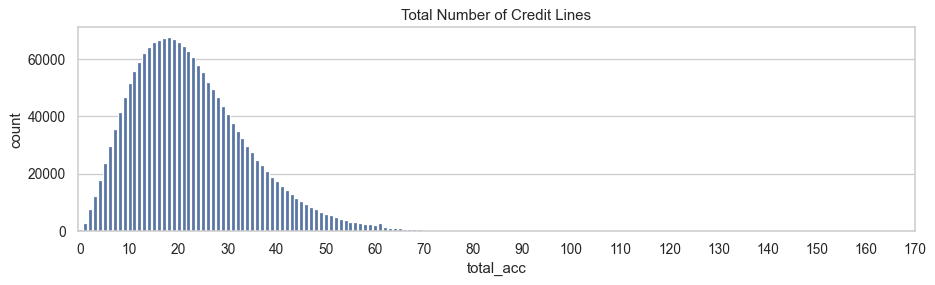

In [105]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans['total_acc'], order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [106]:
loans.groupby('loan_status')['total_acc'].describe()

count     mean      std  min   25%   50%   75%    max
loan_status                                                           
Charged Off   362548.0  24.2129  12.1633  2.0  15.0  22.0  31.0  176.0
Fully Paid   1497783.0  24.6895  12.0159  2.0  16.0  23.0  31.0  165.0

No large differences here.

### 3.2.24 initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." I'm not sure what this means.

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



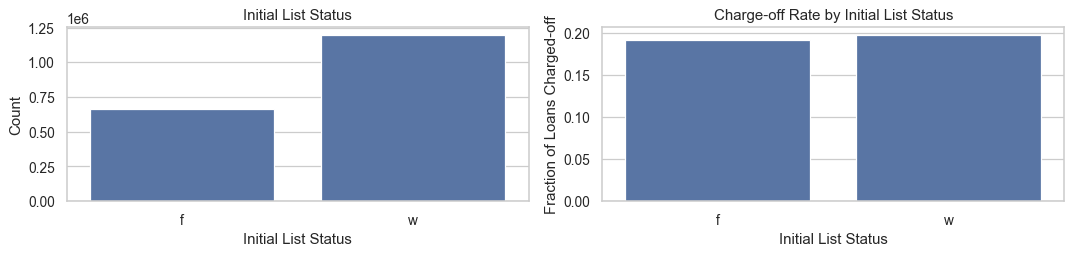

In [107]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

### 3.2.25 application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [108]:
loans['application_type'].value_counts()

Individual    1790838
Joint App       69493
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [109]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.1929
Joint App     0.2462
Name: loan_status, dtype: float64

Joint loans are slightly less likely to be charged-off.

### 3.2.26 mort_acc

Data Dictionary: "Number of mortgage accounts."

In [110]:
loans['mort_acc'].describe()

count    1.8130e+06
mean     1.6066e+00
std      1.9451e+00
min      0.0000e+00
25%      0.0000e+00
50%      1.0000e+00
75%      3.0000e+00
max      6.1000e+01
Name: mort_acc, dtype: float64

Not sure how someone can have 51 mortgage accounts...but apparently they do. Check the top 10 values:

In [111]:
loans['mort_acc'].value_counts().head(10)

0.0    747953
1.0    319708
2.0    266554
3.0    191975
4.0    127349
5.0     75161
6.0     41412
7.0     21061
8.0     10418
9.0      5277
Name: mort_acc, dtype: int64

In [112]:
total_acc_avg = loans.groupby('total_acc').mean()['mort_acc'].fillna(0)

def fill_mort_acc(total_acc,mort_acc):
    '''
    Accepts the total_acc and mort_acc values for the row.
    Checks if the mort_acc is NaN , if so, it returns the avg mort_acc value
    for the corresponding total_acc value for that row.
    
    total_acc_avg here should be a Series or dictionary containing the mapping of the
    groupby averages of mort_acc per total_acc values.
    '''
    if mort_acc>=0:
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [113]:
loans['mort_acc'] = loans.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

Compare the summary statistics by loan status:

In [114]:
loans.groupby('loan_status')['mort_acc'].describe()

count    mean     std  min     25%     50%     75%      max
loan_status                                                                 
Charged Off   355662.0  1.5752  0.7621  0.0  0.9295  1.5731  2.1987   9.2857
Fully Paid   1457388.0  1.6142  0.7517  0.0  1.0160  1.6457  2.2662  11.0000

Individuals who pay off their loans are more likely to have several mortgage accounts.

### 3.2.27 pub_rec_bankruptcies

Data Dictionary: "Number of public record bankruptcies."

In [115]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.0     1628840
1.0      218344
2.0        9723
3.0        1952
4.0         505
5.0         177
6.0          58
7.0          21
8.0           9
9.0           3
11.0          1
12.0          1
Name: pub_rec_bankruptcies, dtype: int64

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



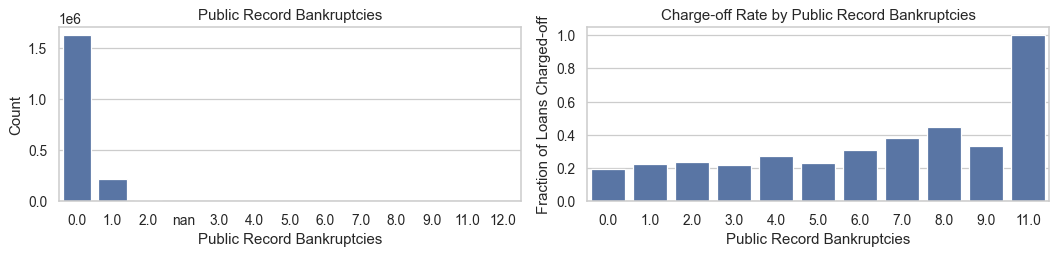

In [116]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

<a id="4"></a>
# 4. More Pre-processing

<a id="4.1"></a>
## 4.1 Convert loan status to 0/1 charge-off indicator

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [117]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [118]:
loans = loans.dropna().reset_index(drop=True)

<a id="4.2"></a>
## 4.2 Create dummy variables

How many variables do we currently have?

In [119]:
loans.shape

(1810610, 24)

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:

In [120]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [121]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

Series([], dtype: float64)


There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [122]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'verification_status', 'issue_d', 'purpose',
       'addr_state', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score',
       'log_revol_bal', 'charged_off'],
      dtype='object')


In [123]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

How many variables are there now?

In [124]:
loans.shape

(1810610, 121)

Check our data with the new dummy variables:

In [125]:
loans.sample(5)

loan_amnt  term  int_rate  installment   issue_d    dti  \
57985       9000.0    36     17.56       323.39  Aug-2013   8.27   
535670      6000.0    36      6.46       183.79  Feb-2019  22.71   
1409930    23875.0    36     16.29       842.80  May-2016  36.08   
1464767     4000.0    36     17.99       144.59  Sep-2016  28.99   
1274020    18500.0    36      9.75       594.78  Mar-2016  26.35   

         earliest_cr_line  open_acc  pub_rec  revol_util  total_acc  mort_acc  \
57985                2000       7.0      0.0        64.2       19.0    1.3075   
535670               2010      10.0      0.0         6.1       25.0    1.8113   
1409930              1983      16.0      0.0        82.3       21.0    1.4771   
1464767              2010       7.0      1.0        52.9        8.0    0.3260   
1274020              1995       7.0      0.0        84.7       20.0    1.3781   

         pub_rec_bankruptcies  log_annual_inc  fico_score  log_revol_bal  \
57985                     0.0          4.6721       672.0         3.6695   
535670                    0.0          5.0607       777.0         3.5250   
1409930                   0.0          4.6711       672.0         4.0123   
1464767                   1.0          4.6532       667.0         3.9789   
1274020                   0.0          4.6128       722.0         4.2244   

         charged_off  sub_grade_A2  sub_grade_A3  sub_grade_A4  sub_grade_A5  \
57985              0             0             0             0             0   
535670             0             0             0             0             0   
1409930            0             0             0             0             0   
1464767            0             0             0             0             0   
1274020            0             0             0             0             0   

         sub_grade_B1  sub_grade_B2  sub_grade_B3  sub_grade_B4  sub_grade_B5  \
57985               0             0             0             0             0   
535670              0             0             0             0             0   
1409930             0             0             0             0             0   
1464767             0             0             0             0             0   
1274020             0             0             1             0             0   

         sub_grade_C1  sub_grade_C2  sub_grade_C3  sub_grade_C4  sub_grade_C5  \
57985               0             0             0             0             0   
535670              0             0             0             0             0   
1409930             0             0             0             0             0   
1464767             0             0             0             0             0   
1274020             0             0             0             0             0   

         sub_grade_D1  sub_grade_D2  sub_grade_D3  sub_grade_D4  sub_grade_D5  \
57985               1             0             0             0             0   
535670              0             0             0             0             0   
1409930             1             0             0             0             0   
1464767             0             1             0             0             0   
1274020             0             0             0             0             0   

         sub_grade_E1  sub_grade_E2  sub_grade_E3  sub_grade_E4  sub_grade_E5  \
57985               0             0             0             0             0   
535670              0             0             0             0             0   
1409930             0             0             0             0             0   
1464767             0             0             0             0             0   
1274020             0             0             0             0             0   

         sub_grade_F1  sub_grade_F2  sub_grade_F3  sub_grade_F4  sub_grade_F5  \
57985               0             0             0             0             0   
535670              0             0             0             0  

<a id="4.3"></a>
## 4.3 Train/test split

In [126]:
# We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.
# loans['issue_d'].sample(5)

# Are there any missing values?
# loans['issue_d'].isnull().any()

# No. Let's convert the issue dates to datetime objects:
# loans['issue_d'] = pd.to_datetime(loans['issue_d'])
# loans['issue_d'].sample(5)

# The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:
# loans['issue_d'].describe()
# There are only 154 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in March 2020. The busiest month was March 2016 with 57,553 loans funded in that month. What is the distribution of loans funded in each year?

# plt.figure(figsize=(6,3), dpi=90)
# loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
# plt.xlabel('Year')
# plt.ylabel('Number of Loans Funded')
# plt.title('Loans Funded per Year')

# We'll form the test set from the most recent 10% of the loans.

# loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
# loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]
# Refer [this video](https://www.youtube.com/watch?v=idXEk3MjC9M) if you didn't understood the quantile. Check that we properly partitioned the loans:

# What is the test size?
# loans_test.shape[0] / loans.shape[0]
# About 10.8%. The partition looks good, so we can delete the original `loans` dataframe:
# The training set includes loans from June 2007 to April 2018. The test set includes loans from May 2018 to March 2020. Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

# del loans

# loans_train.drop('issue_d', axis=1, inplace=True)
# loans_test.drop('issue_d', axis=1, inplace=True)

# del loans_train, loans_test

# y_train = loans_train['charged_off']
# y_test = loans_test['charged_off']

# X_train = loans_train.drop('charged_off', axis=1)
# X_test = loans_test.drop('charged_off', axis=1)

In [127]:
loans.drop('issue_d', axis=1, inplace=True)

In [159]:
# Features
X = loans.drop('charged_off',axis=1)

# Label
y = loans['charged_off']

In [160]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [161]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape:  ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape:  ", y_test.shape)

X_train.shape:  (1448488, 119)
X_test.shape:   (362122, 119)
y_train.shape:  (1448488,)
y_test.shape:   (362122,)


<a id="5"></a>
# 5. Linear Dependence of Charge-off on the Predictors

On the training set, we compute the [Pearson correlation](https://www.youtube.com/watch?v=6fUYt1alA1U), $F$-statistic, and $p$ value of each predictor with the response variable `charged_off`.

In [131]:
linear_dep = pd.DataFrame()

<a id="5.1"></a>
## 5.1 Pearson correlation
We use the Pearson correlation coefficient to examine the strength and direction of the linear relationship between two continuous variables.

The correlation coefficient can range in value from −1 to +1. The larger the absolute value of the coefficient, the stronger the relationship between the variables. For the Pearson correlation, an absolute value of 1 indicates a perfect linear relationship. A correlation close to 0 indicates no linear relationship between the variables. 

The sign of the coefficient indicates the direction of the relationship. If both variables tend to increase or decrease together, the coefficient is positive, and the line that represents the correlation slopes upward. If one variable tends to increase as the other decreases, the coefficient is negative, and the line that represents the correlation slopes downward.

* We can see a strong correlation between loan_amnt and installment. (The monthly payment owed by the borrower if the loan originates)

In [132]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

In [133]:
linear_dep

pearson_corr  abs_pearson_corr
loan_amnt                                  0.0706            0.0706
term                                       0.1690            0.1690
int_rate                                   0.2540            0.2540
installment                                0.0587            0.0587
dti                                        0.0639            0.0639
earliest_cr_line                           0.0459            0.0459
open_acc                                   0.0199            0.0199
pub_rec                                    0.0230            0.0230
revol_util                                 0.0484            0.0484
total_acc                                 -0.0165            0.0165
mort_acc                                  -0.0208            0.0208
pub_rec_bankruptcies                       0.0265            0.0265
log_annual_inc                            -0.0615            0.0615
fico_score                                -0.1194            0.1194
log_revol_bal                             -0.0126            0.0126
sub_grade_A2                              -0.0639            0.0639
sub_grade_A3                              -0.0604            0.0604
sub_grade_A4                              -0.0630            0.0630
sub_grade_A5                              -0.0606            0.0606
sub_grade_B1                              -0.0548            0.0548
sub_grade_B2                              -0.0477            0.0477
sub_grade_B3                              -0.0402            0.0402
sub_grade_B4                              -0.0307            0.0307
sub_grade_B5                              -0.0194            0.0194
sub_grade_C1                              -0.0052            0.0052
sub_grade_C2                               0.0070            0.0070
sub_grade_C3                               0.0186            0.0186
sub_grade_C4                               0.0321            0.0321
sub_grade_C5                               0.0387            0.0387
sub_grade_D1                               0.0388            0.0388
sub_grade_D2                               0.0460            0.0460
sub_grade_D3                               0.0483            0.0483
sub_grade_D4                               0.0520            0.0520
sub_grade_D5                               0.0540            0.0540
sub_grade_E1                               0.0481            0.0481
sub_grade_E2                               0.0503            0.0503
sub_grade_E3                               0.0535            0.0535
sub_grade_E4                               0.0524            0.0524
sub_grade_E5                               0.0580            0.0580
sub_grade_F1                               0.0445            0.0445
sub_grade_F2                               0.0425            0.0425
sub_grade_F3                               0.0385            0.0385
sub_grade_F4                               0.0379            0.0379
sub_grade_F5                               0.0359            0.0359
sub_grade_G1                               0.0306            0.0306
sub_grade_G2                               0.0255            0.0255
sub_grade_G3                               0.0238            0.0238
sub_grade_G4                               0.0238            0.0238
sub_grade_G5                               0.0226            0.0226
home_ownership_OTHER                       0.0003            0.0003
home_ownership_OWN                         0.0047            0.0047
home_ownership_RENT                        0.0657            0.0657
verification_status_Source Verified        0.0132            0.0132
verification_status_Verified               0.0628            0.0628
purpose_credit_card                       -0.0364            0.0364
purpose_debt_consolidation                 0.0331            0.0331
purpose_educational                       -0.0004            0.0004
purpose_home_improvement                  -0.0148            0.0148
purpose_house            

$F$-statistics:

In [134]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [135]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [136]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with `charged_off`:

In [137]:
linear_dep.head(30)

variable  pearson_corr           F  p_value
0                       int_rate        0.2540  99925.2512      0.0
1                           term        0.1690  42590.8883      0.0
2                     fico_score       -0.1194  20937.9775      0.0
3                      loan_amnt        0.0706   7248.7055      0.0
4            home_ownership_RENT        0.0657   6287.7696      0.0
5                   sub_grade_A2       -0.0639   5943.2444      0.0
6                            dti        0.0639   5938.5575      0.0
7                   sub_grade_A4       -0.0630   5775.0384      0.0
8   verification_status_Verified        0.0628   5740.1374      0.0
9                 log_annual_inc       -0.0615   5500.9651      0.0
10                  sub_grade_A5       -0.0606   5331.7764      0.0
11                  sub_grade_A3       -0.0604   5297.2539      0.0
12                   installment        0.0587   5008.4254      0.0
13                  sub_grade_E5        0.0580   4887.3351      0.0
14                  sub_grade_B1       -0.0548   4363.7033      0.0
15                  sub_grade_D5        0.0540   4229.2016      0.0
16                  sub_grade_E3        0.0535   4150.8384      0.0
17                  sub_grade_E4        0.0524   3991.2166      0.0
18                  sub_grade_D4        0.0520   3920.7495      0.0
19                  sub_grade_E2        0.0503   3670.0409      0.0
20                    revol_util        0.0484   3402.4683      0.0
21                  sub_grade_D3        0.0483   3384.2204      0.0
22                  sub_grade_E1        0.0481   3354.9387      0.0
23                  sub_grade_B2       -0.0477   3299.2963      0.0
24                  sub_grade_D2        0.0460   3070.9537      0.0
25              earliest_cr_line        0.0459   3055.5958      0.0
26                  sub_grade_F1        0.0445   2870.9591      0.0
27                  sub_grade_F2        0.0425   2619.4453      0.0
28                  sub_grade_B3       -0.0402   2343.3164      0.0
29                  sub_grade_D1        0.0388   2188.7583      0.0

The variables most linearly correlated with `charged_off` are the interest rate, loan period (term), FICO score, debt-to-income ratio, number of mortgages, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [138]:
linear_dep.tail(20)

variable  pearson_corr       F  p_value
99              addr_state_MO        0.0023  7.6653   0.0056
100             addr_state_TN        0.0022  7.3217   0.0068
101           purpose_medical        0.0022  7.1296   0.0076
102             addr_state_AZ       -0.0020  5.9065   0.0151
103             addr_state_IA        0.0017  4.1017   0.0428
104             addr_state_HI        0.0016  3.5989   0.0578
105             addr_state_NC        0.0015  3.4212   0.0644
106  purpose_renewable_energy        0.0015  3.4174   0.0645
107             addr_state_KY        0.0014  2.8849   0.0894
108             addr_state_DE       -0.0011  1.7907   0.1808
109             addr_state_MN       -0.0011  1.7868   0.1813
110             addr_state_ND       -0.0010  1.5832   0.2083
111             addr_state_OH       -0.0010  1.5772   0.2092
112             addr_state_VA       -0.0008  0.9656   0.3258
113             addr_state_MI       -0.0008  0.8900   0.3455
114             addr_state_CA       -0.0004  0.2725   0.6017
115       purpose_educational       -0.0004  0.2438   0.6215
116             addr_state_SD        0.0004  0.2118   0.6454
117      home_ownership_OTHER        0.0003  0.0912   0.7626
118             addr_state_TX        0.0001  0.0233   0.8788

It looks like the borrower's state of residence, the revolving balance, and several of the loan purposes are irrelevant for predicting charge-off.

<a id="6"></a>
# 6. Model Training and Testing

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Logistic regression with SGD training
2. Random forest

We'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

In [153]:
scaler = MinMaxScaler()

# fit and transfrom
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# everything has been scaled between 1 and 0
print('Max: ',X_train.max())
print('Min: ', X_train.min())

Max:  1.0000000000000004
Min:  0.0


<a id="6.1"></a>
## 6.1 Logistic regression with SGD training

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

The machine learning pipeline:

In [141]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

A small grid of hyperparameters to search over:

In [142]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [143]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [144]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=1,
             param_grid={'model__alpha': [1e-05, 0.01, 10],
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [145]:
grid_sgdlogreg.best_score_

0.705849170214228

Best hyperparameters:

In [146]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

<a id="6.2"></a>
## 6.2 Random forest classifier

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

In [147]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

In [148]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

The AUROC will always improve (with decreasing gains) as the number of estimators increases, but it's not necessarily worth the extra training time and model complexity.

In [149]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [150]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=1, param_grid={'model__n_estimators': [50]}, pre_dispatch=1,
             scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the random forest:

In [151]:
grid_rfc.best_score_

0.6922500368673525

Not quite as good as logistic regression, at least according to this metric.

<a id="6.4"></a>
## 6.4 Tune hyperparameters on the chosen model more finely

The three models performed quite similarly according to the AUROC:

In [152]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')

Cross-validated AUROC scores
0.705849170214228 - Logistic regression
0.6922500368673525 - Random forest


Logistic regression squeaked out ahead, and coupled with the fact that `SGDClassifier` trains much faster than the other two models, we'll select logistic regression as our final model. Now we'll tune the hyperparameters more finely.

In [153]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}

print(param_grid_sgdlogreg)

{'model__alpha': array([3.16227766e-05, 1.00000000e-04, 3.16227766e-04, 1.00000000e-03,
       3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00]), 'model__penalty': ['l1', 'l2']}


In [154]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [155]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed: 33.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=1,
             param_grid={'model__alpha': array([3.16227766e-05, 1.00000000e-04, 3.16227766e-04, 1.00000000e-03,
       3.16227766e-03, 1.00000000e-02, 3.16227766e-02, 1.00000000e-01,
       3.16227766e-01, 1.00000000e+00, 3.16227766e+00]),
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [156]:
grid_sgdlogreg.best_score_

0.7058472102563582

Best hyperparameters:

In [157]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

By some coincidence, the optimal hyperparameters here are the same as from our first grid search for logistic regression!

<a id="6.5"></a>
## 6.5 Test set evaluation

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the loans).

In [158]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.6899233896732194

The test set AUROC score is somewhat lower than the cross-validated score (0.713).

## Shapley Value

### SHAP Values
- Shap values show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature).
- In addition to this nice breakdown for each prediction, the Shap library offers great visualizations of groups of Shap values. These visualizations have conceptual similarities to permutation importance and partial dependence plots.

In [141]:
from xgboost import XGBClassifier

In [162]:
%%time
my_model = XGBClassifier(n_estimators=100).fit(X_train, y_train)

C:\Users\ykamd\.conda\envs\ve1\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3min 17s


In [168]:
X_test.head()

loan_amnt  term  int_rate  installment    dti  earliest_cr_line  \
1174390    15000.0    60     15.61       361.67   9.96              2002   
304775     14000.0    60     10.42       300.37   1.73              2006   
1714051     3600.0    36     15.99       126.55  28.63              2002   
1485291    25600.0    36     14.49       881.06  16.90              1985   
365102     21000.0    60     18.06       533.95  20.48              2005   

         open_acc  pub_rec  revol_util  total_acc  mort_acc  \
1174390      24.0      1.0        49.5       30.0    2.1438   
304775        7.0      1.0        61.0       19.0    1.3075   
1714051      21.0      0.0        63.3       37.0    2.4758   
1485291      12.0      0.0        69.9       15.0    0.9295   
365102       13.0      0.0        47.6       28.0    2.0141   

         pub_rec_bankruptcies  log_annual_inc  fico_score  log_revol_bal  \
1174390                   1.0          4.9031       707.0         3.3883   
304775                    1.0          5.3979       747.0         4.4535   
1714051                   0.0          5.0253       682.0         4.4527   
1485291                   0.0          5.1206       687.0         4.3912   
365102                    0.0          4.7993       687.0         4.3768   

         sub_grade_A2  sub_grade_A3  sub_grade_A4  sub_grade_A5  sub_grade_B1  \
1174390             0             0             0             0             0   
304775              0             0             0             0             0   
1714051             0             0             0             0             0   
1485291             0             0             0             0             0   
365102              0             0             0             0             0   

         sub_grade_B2  sub_grade_B3  sub_grade_B4  sub_grade_B5  sub_grade_C1  \
1174390             0             0             0             0             0   
304775              0             1             0             0             0   
1714051             0             0             0             0             0   
1485291             0             0             0             0             0   
365102              0             0             0             0             0   

         sub_grade_C2  sub_grade_C3  sub_grade_C4  sub_grade_C5  sub_grade_D1  \
1174390             0             0             0             0             1   
304775              0             0             0             0             0   
1714051             0             0             0             1             0   
1485291             0             0             1             0             0   
365102              0             0             0             0             0   

         sub_grade_D2  sub_grade_D3  sub_grade_D4  sub_grade_D5  sub_grade_E1  \
1174390             0             0             0             0             0   
304775              0             0             0             0             0   
1714051             0             0             0             0             0   
1485291             0             0             0             0             0   
365102              1             0             0             0             0   

         sub_grade_E2  sub_grade_E3  sub_grade_E4  sub_grade_E5  sub_grade_F1  \
1174390             0             0             0             0             0   
304775              0             0             0             0             0   
1714051             0             0             0             0             0   
1485291             0             0             0             0             0   
365102              0             0             0             0             0   

         sub_grade_F2  sub_grade_F3  sub_grade_F4  sub_grade_F5  sub_grade_G1  \
1174390             0             0             0             0             0   
304775              0             0             0             0             0   
1714051             0             0   

### Summary Plots
One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?

This concept is called feature importance.

There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

Shap's Summary Plots are created on the basis of permutation importance. Compared to most other approaches, permutation importance is:

- fast to calculate,
- widely used and understood, and
- consistent with properties we would want a feature importance measure to have.

Link for detailed explanation: https://www.kaggle.com/dansbecker/permutation-importance    


Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

- a large effect for a few predictions, but no effect in general, or
- a medium effect for all predictions.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. Below we have plotted the <strong> Summary Plot </strong>. 
The <strong>"Feature Number"</strong> corresponds to the <strong>column number</strong> in our Test dataset.

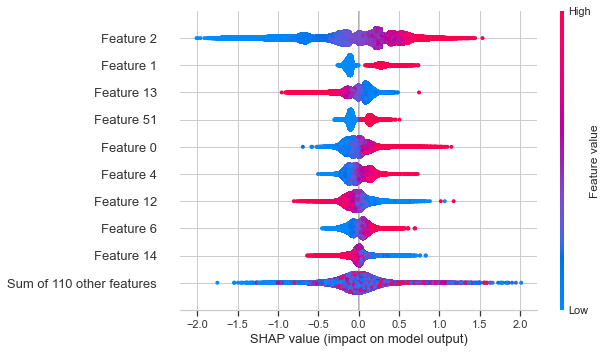

In [146]:
%%time
import shap
shap.initjs()
# compute SHAP values
explainer = shap.Explainer(my_model)
shap_values = explainer(X_test)
#summary_plot
shap.plots.beeswarm(shap_values)

This plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

For example, the point on the extreme left of Feature 2 that corresponds to lower values for "Interest Rate" and it reduces the prediction by 2.0.

Some things you should be able to easily pick out:
- High values of "Feature 2 (Interest Rate)" caused higher predictions, and low values caused low predictions.
- High values of "Feature 13 (Fico Score)" caused lower predictions, and low values caused higher predictions.
- High values of "Feature 0 (Loan Amount)" caused higher predictions, and low values caused a feeble (0.25) decrease in predictions.

If you look for long enough, there's a lot of information in this graph.

In [193]:
X_test.columns.values[0]

'loan_amnt'

<a id="7"></a>
# 7. Conclusion

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off. After training and evaluating different models (logistic regression, random forest, and k-nearest neighbors), we found that all models performed similarly according to a cross-validated AUROC score on the training data. We selected logistic regression (with ridge penalty) because it was the fastest model to train, and this model obtained an AUROC score of 0.689 on a test set consisting of the most recent 10% of the loans.

This model, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.

We also found that, according to linear measures of correlation between the predictors and the response, the most important variables for predicting charge-off are the loan interest rate and term, and the borrower's FICO score and debt-to-income ratio.